<a href="https://colab.research.google.com/github/VShalini01/MiniProject-3-2-/blob/main/Mini_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, TFSMLayer
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kausthubkannan/ai-and-human-art-classification")

print("Path to dataset files:", path)

100%|██████████| 2.21G/2.21G [00:26<00:00, 90.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kausthubkannan/ai-and-human-art-classification/versions/1


In [4]:
import os

parent_dir = "/root/.cache/kagglehub/datasets/kausthubkannan/ai-and-human-art-classification/versions/1/"
print(os.listdir(parent_dir))

['ai_art_classification']


In [5]:
import tensorflow as tf
import os

size = 240
channel = 3

train_dir = "/root/.cache/kagglehub/datasets/kausthubkannan/ai-and-human-art-classification/versions/1/ai_art_classification/train"

data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    color_mode=("grayscale" if channel == 1 else "rgb"),
    image_size=(size, size),
    label_mode="categorical",
    class_names=["NON_AI_GENERATED", "AI_GENERATED"]
)

data = data.map(lambda x, y: (x / 255, y))

print(os.listdir("/root/.cache/kagglehub/datasets/kausthubkannan/ai-and-human-art-classification/versions/1/ai_art_classification/"))

Found 18618 files belonging to 2 classes.
['train', 'test']


In [6]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
print(f"Image Shape: {batch[0].shape}")
print(f"Label Shape: {batch[1].shape}")

Image Shape: (32, 240, 240, 3)
Label Shape: (32, 2)


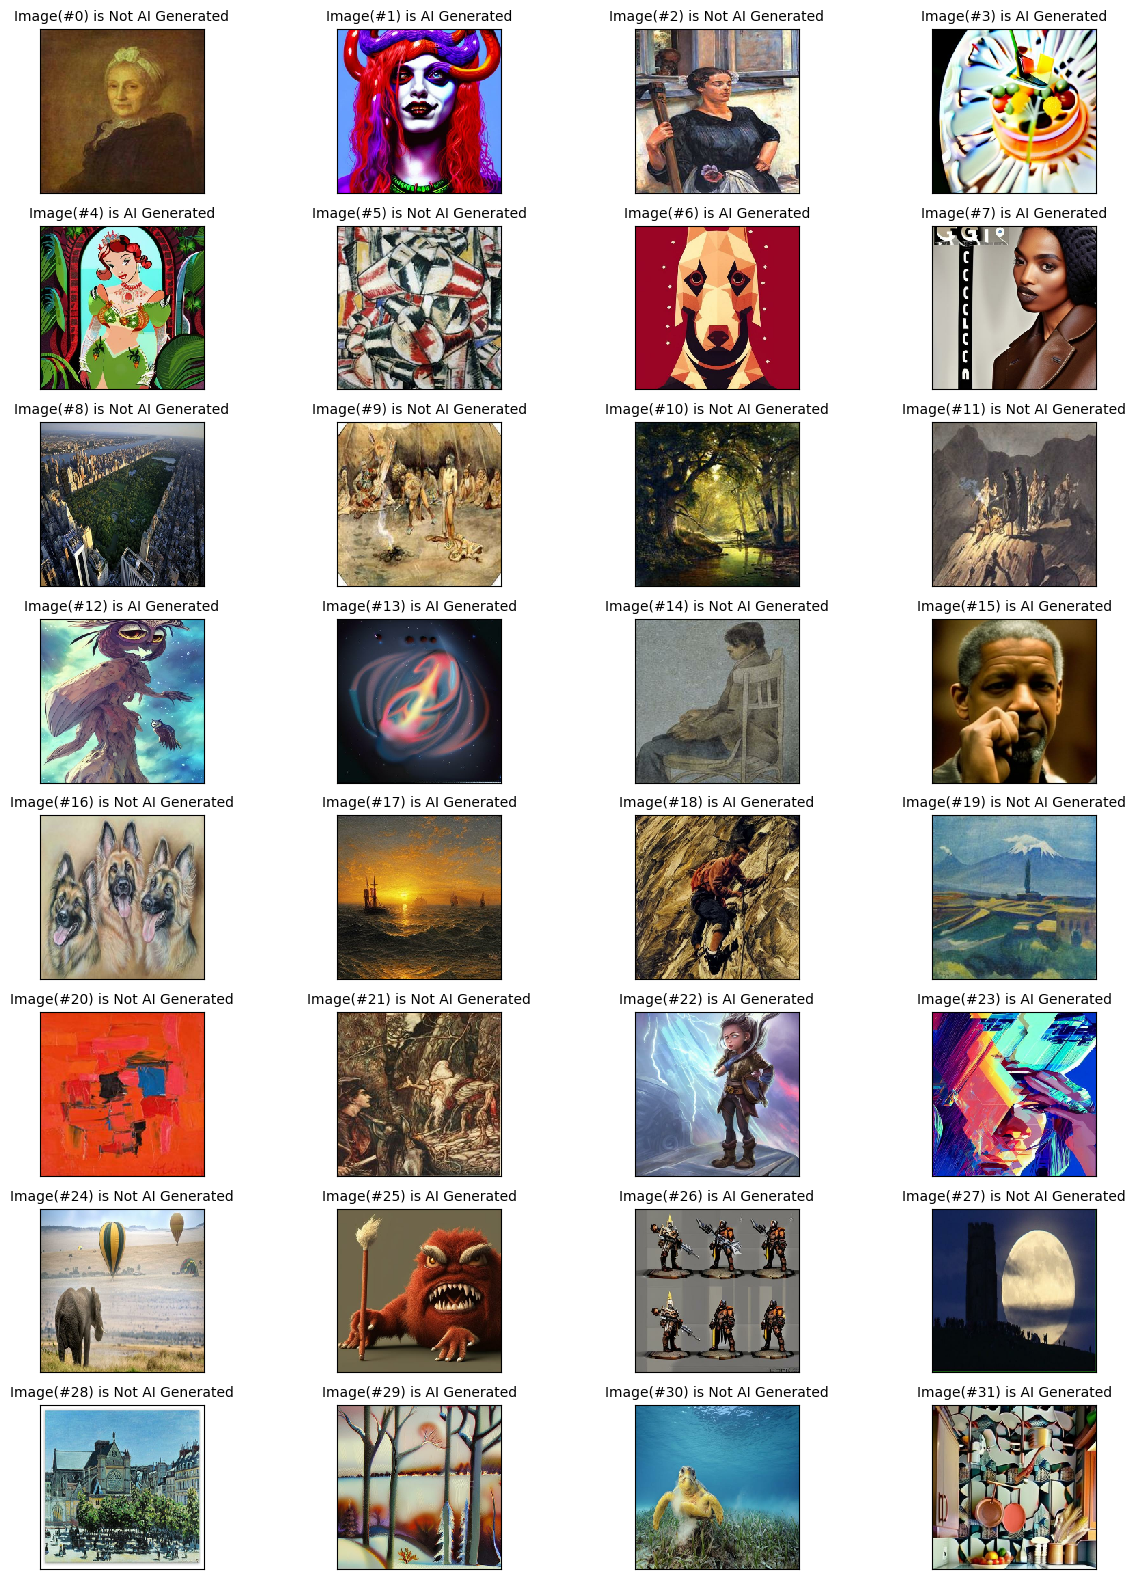

In [7]:
def plot_image(data, label):
    fig, axes = plt.subplots(8, 4, figsize=(15, 20),
    subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.2,wspace=0.1))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(data[i].reshape(size, size, channel),
            cmap='gray', interpolation='nearest')
        if(label[i][0] > label[i][1]):
            ax.set_title(f"Image(#{i}) is Not AI Generated", size=10)
        else:
            ax.set_title(f"Image(#{i}) is AI Generated", size=10)
plot_image(batch[0], batch[1])

In [8]:
print(f"{len(data)} batches")
train_size = round(len(data)*.8)
val_size = round(len(data)*.1)
test_size = round(len(data)*.1)
if(train_size+val_size+test_size < len(data)):
    train_size += len(data) % (train_size+val_size+test_size)

val = data.take(val_size)
test = data.skip(val_size).take(test_size)
train = data.skip(val_size+test_size).take(train_size)
print(f"Train: {train_size} batches")
print(f"Validation: {val_size} batches")
print(f"Test: {test_size} batches")

582 batches
Train: 466 batches
Validation: 58 batches
Test: 58 batches


In [9]:
archi = tf.keras.applications.EfficientNetB1(include_top = False,input_shape = (size, size, channel),pooling="avg", weights="imagenet")
archi.trainable = False

input_layer = tf.keras.Input(shape=(size, size, channel))

x = archi(input_layer, training=False)
# x = keras.layers.Dropout(0.2, name="top_dropout")(x)
output = Dense(2, activation="softmax")(x)
model = tf.keras.Model(input_layer, output)
epoch = 20

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.summary()
model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy',metrics=['binary_accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb1 (Functional)          │ (None, 1280)                │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,577,801 (25.09 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 6,575,239 (25.08 MB)

In [11]:
import time
start_time = time.time()

# log_dir= "log"
# callbacks = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks = EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights = True)

hist = model.fit(train, epochs=epoch,verbose=1, validation_data=val, callbacks=[callbacks])
elapsed_time = time.time() - start_time
print(f'elapsed train time: {elapsed_time}')

score = model.evaluate(val, verbose=0)
print(f"Validation loss: {score[0]}")
print(f"Validation accuracy: {score[1]}")

Epoch 1/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 95s 117ms/step - binary_accuracy: 0.5523 - loss: 0.6855 - val_binary_accuracy: 0.5528 - val_loss: 0.6696
Epoch 2/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 38s 68ms/step - binary_accuracy: 0.5676 - loss: 0.6753 - val_binary_accuracy: 0.5598 - val_loss: 0.6739
Epoch 3/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 38s 69ms/step - binary_accuracy: 0.5680 - loss: 0.6728 - val_binary_accuracy: 0.5727 - val_loss: 0.6612
Epoch 4/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 38s 68ms/step - binary_accuracy: 0.5869 - loss: 0.6687 - val_binary_accuracy: 0.5911 - val_loss: 0.6576
Epoch 5/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - binary_accuracy: 0.5801 - loss: 0.6721 - val_binary_accuracy: 0.5577 - val_loss: 0.6613
Epoch 6/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - binary_accuracy: 0.5785 - loss: 0.6716 - val_binary_accuracy: 0.5566 - val_loss: 0.6587
Epoch 7/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - binary_accuracy: 0.5747 - loss: 0.6732 - val_binary_accuracy: 0.5970 - val_loss

In [12]:
archi.trainable = True
model.summary()
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy',metrics=['binary_accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb1 (Functional)          │ (None, 1280)                │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,582,927 (25.11 MB)

 Trainable params: 6,515,746 (24.86 MB)

 Non-trainable params: 62,055 (242.41 KB)

 Optimizer params: 5,126 (20.03 KB)

In [13]:
import tensorflow as tf
import time
start_time = time.time()

# log_dir= "log"
# callbacks = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks = EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights = True)

hist = model.fit(train, epochs=epoch,verbose=1, validation_data=val, callbacks=[callbacks])
elapsed_time = time.time() - start_time
print(f'elapsed train time: {elapsed_time}')

score = model.evaluate(val, verbose=0)
print(f"Validation loss: {score[0]}")
print(f"Validation accuracy: {score[1]}")

Epoch 1/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 271s 339ms/step - binary_accuracy: 0.8595 - loss: 0.3169 - val_binary_accuracy: 0.5997 - val_loss: 0.6280
Epoch 2/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 108s 218ms/step - binary_accuracy: 0.9520 - loss: 0.1236 - val_binary_accuracy: 0.8206 - val_loss: 0.4661
Epoch 3/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 109s 220ms/step - binary_accuracy: 0.9698 - loss: 0.0762 - val_binary_accuracy: 0.6395 - val_loss: 0.8342
Epoch 4/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 109s 220ms/step - binary_accuracy: 0.9867 - loss: 0.0473 - val_binary_accuracy: 0.7306 - val_loss: 0.6783
Epoch 5/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 108s 220ms/step - binary_accuracy: 0.9885 - loss: 0.0345 - val_binary_accuracy: 0.7020 - val_loss: 0.7452
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
elapsed train time: 704.8851985931396
Validation loss: 0.4612099826335907
Validation accuracy: 0.8254310488700867


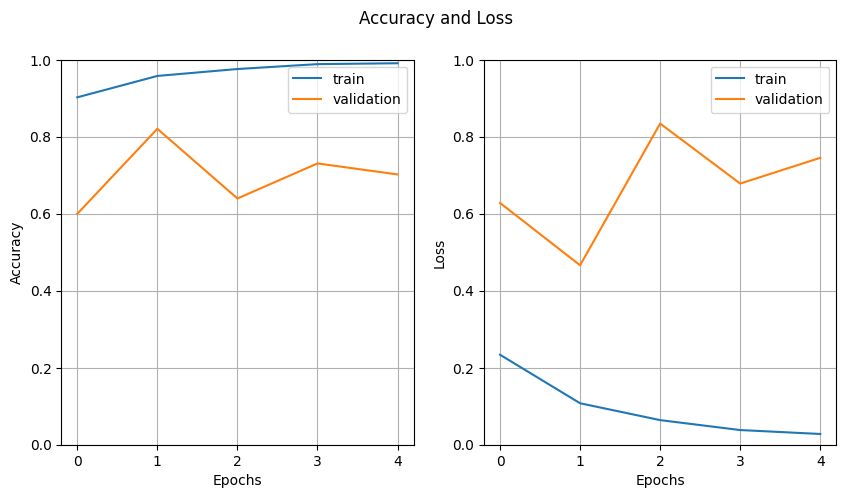

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(hist.history['binary_accuracy'])
ax[0].plot(hist.history['val_binary_accuracy'])
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epochs")
ax[0].axis(ymin=0, ymax=1)
ax[0].legend(["train", "validation"])
ax[0].grid()
ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epochs")
ax[1].axis(ymin=0, ymax=1)
ax[1].legend(["train", "validation"])
ax[1].grid()
plt.xlabel("Epochs")
fig.suptitle("Accuracy and Loss")
plt.show()

In [15]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

elapsed inference time: 40.966548681259155
Precision: 0.7686395049095154
Recall: 0.9765625
Accuracy: 0.8248922228813171


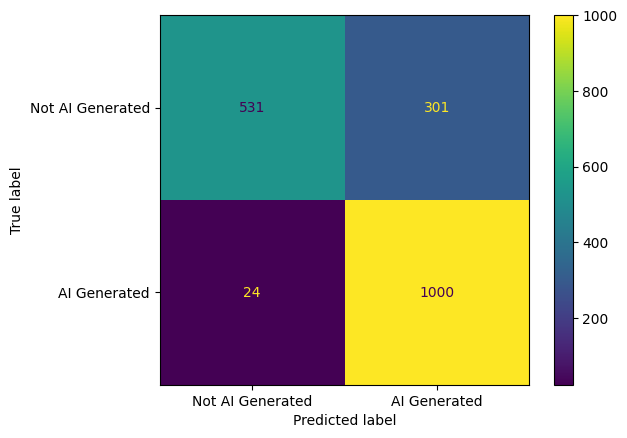

In [16]:
from sklearn import metrics

y_test = []
y_pred = []

start_time = time.time()
for batch in test.as_numpy_iterator():
    x_test, y_test_temp = batch
    y_test.extend(y_test_temp)
    y_pred_temp = model.predict(x_test, verbose=0)
    y_pred.extend(y_pred_temp)
elapsed_time = time.time() - start_time
print(f'elapsed inference time: {elapsed_time}')
pre.update_state(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
re.update_state(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
acc.update_state(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(f"Precision: {pre.result().numpy()}")
print(f"Recall: {re.result().numpy()}")
print(f"Accuracy: {acc.result().numpy()}")
conf_mat = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)),display_labels = ["Not AI Generated", "AI Generated"])

conf_mat.plot()

In [17]:
import os
model_temp = model
model.export('effnetb1.pb')

Saved artifact at 'effnetb1.pb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name='keras_tensor_341')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132166624561104: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132166624561680: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132165040060368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132165040057104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132165040059408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132165040060944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132165040061520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132166618662096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132166618664592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132166618663248: TensorSpec(shape=(), dtype=tf.resource, name=None)